There is a total of 4 district objects in this image

---- Data for component: 0 ----

	i. Area: 13139 Pixel^2
	ii. Centriod: xc, yc: 207.330, 91.735
	iii .Bounding box : x1, y1: [141, 23] x2, y2: [270, 165]
	iv. Orientation of the axis of elongation: -0.8625
	v. Eccentricity: 0.922, Perimeter: 448.174 and Compactness: 15.287 



---- Data for component: 1 ----

	i. Area: 19742 Pixel^2
	ii. Centriod: xc, yc: 361.075, 146.547
	iii .Bounding box : x1, y1: [211, 46] x2, y2: [503, 239]
	iv. Orientation of the axis of elongation: -0.3415
	v. Eccentricity: 0.425, Perimeter: 876.497 and Compactness: 38.914 



---- Data for component: 2 ----

	i. Area: 15311 Pixel^2
	ii. Centriod: xc, yc: 81.309, 196.629
	iii .Bounding box : x1, y1: [7, 61] x2, y2: [134, 334]
	iv. Orientation of the axis of elongation: 1.3786
	v. Eccentricity: 0.269, Perimeter: 819.813 and Compactness: 43.896 



---- Data for component: 3 ----

	i. Area: 8907 Pixel^2
	ii. Centriod: xc, yc: 207.208, 269.835
	iii .Bounding box

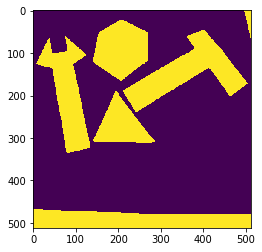

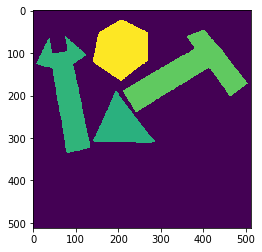

In [11]:
# import cv2 # only needed if you want to see bounding boxes
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import math
from absl import app, flags
from absl.flags import FLAGS

"""
Author Clint Morris

This algorithm takes two inputs:
    1. Image B
    2. Pixel size threshold
    
From these values it generates:
    1. all component's size
    2. location of each component's centroid
    3. the bounding box of each object
    4. the orientation of the axis of elongation
    5. the eccentricity, perimeter and compactness 
"""

def read_format_img(im_path,bit_thresh,h=512,w=512,header_len=512):
# load .img file
    shape = (h, w) # matrix size
    fid = open(im_path, 'rb')
    dtype = np.dtype('uint8')
    data = np.fromfile(fid, dtype)
    image = data[512:].reshape(shape)

    for x in range(w): # bitwise thresh
        for y in range(h):
            if image[x][y] >= bit_thresh:
                image[x][y] = 0
            else:
                image[x][y] = 1
    return image

def filiter_obj_size(label, size_thresh):
    # --- filiter by size map --- #
    m,n = label.shape
    np.unique(label)
    (unique, counts) = np.unique(label, return_counts=True)
    frequencies = np.asarray((unique, counts)).T

    keep_values = [item[0] for item in frequencies if item[1] > size_thresh]
    keep_values.remove(0)
    # generate map from ID to grayscale value [100-255]
    keep2gray = dict(zip(keep_values, [random.randint(100,254) for x in range(len(keep_values))]))
    # --- combination function filiter by size and collect data for bbox values --- #
    bbox_equiv_i, bbox_equiv_j = {}, {}
    bb_count = 0
    for j in range(m):
        for i in range(n):
            if label[j][i] in keep_values:
                # innit label dict of set i and j
                if label[j][i] not in bbox_equiv_j.keys():
                    bbox_equiv_j[label[j][i]] = {j}
                    bbox_equiv_i[label[j][i]] = {i}
                else:
                    if j not in bbox_equiv_j[label[j][i]]:
                        bbox_equiv_j[label[j][i]].add(j)

                    if i not in bbox_equiv_i[label[j][i]]:
                        bbox_equiv_i[label[j][i]].add(i)
                label[j][i] = keep2gray[label[j][i]]

            else:
                label[j][i] = 0  
    return bbox_equiv_i, bbox_equiv_j, label, keep_values, keep2gray

def draw_bbox(bbox_equiv_i, bbox_equiv_j, label, keep2gray):
    bbox_points = {}
    for key in bbox_equiv_j.keys():
        # top left, bottom right
        points = [0,0,0,0]
        for idx, (item) in enumerate([bbox_equiv_i[key],bbox_equiv_j[key]]):
            points[idx] = min(item)
            points[idx+2] = max(item)
        bbox_points[keep2gray[key]] = points
        # if you want to draw the boxes on the image
#         img = cv2.rectangle(label,(points[0],points[1]),(points[2],points[3]),(255,255,255),3)  
#         plt.imshow(img)
#         plt.show()
    return bbox_points


def re_order(c, b):
    neighborhood8 = [[c[0], c[1]-1],[c[0]-1, c[1]-1],
                    [c[0]-1, c[1]],[c[0]-1, c[1]+1],
                    [c[0], c[1]+1],[c[0]+1, c[1]+1],
                    [c[0]+1, c[1]],[c[0]+1, c[1]-1]]
    #index of 4 and 8 neighbors
    root_2 = 2**(1/2)
    neighbor_dis = [1,root_2,1,root_2,1,root_2,1,root_2]

    for idx, (neighbor) in enumerate(neighborhood8):
        if neighbor == b:
            return (neighborhood8[idx:] + neighborhood8[:idx]), (neighbor_dis[idx:] + neighbor_dis[:idx])

def calc_prim(label):
    m,n = label.shape
    items = [255,0]
    max_row_col = [0,0]
    prims, prim_lens_val = {}, {}
    # raster scan the image until you find an object, then loop around that objects prim.
    # repeat until the bottom right pixel
    while max_row_col != [m-1,n-1]: 
        for row in range(m):
            if row > max_row_col[0]:
                max_row_col[0] = row
            for column in range(n):
                if column > max_row_col[1]:
                    max_row_col[1] = column

                if label[row, column] not in items:
                    c = [row, column]
                    end = True
                    perimeter_pixel = [c]
                    b = [c[0], c[1]-1]
                    prim_lens_val[label[c[0], c[1]]] = 0
                    while True:
                        if len(perimeter_pixel)>1 and (c==perimeter_pixel[0]):
                            perimeter_pixel.pop()
                            break

                        clockwise_order_from_b, neighbor_dis = re_order(c, b)
                        for idx, x in enumerate(clockwise_order_from_b):
                            if label[x[0],x[1]] not in items:
                                perimeter_pixel.append(x)
                                c = x
                                b = clockwise_order_from_b[idx-1]
                                prim_lens_val[label[c[0], c[1]]] += neighbor_dis[idx]
                                break

                    prims[label[c[0], c[1]]] = perimeter_pixel
                    items.append(label[c[0], c[1]])
    return prims, prim_lens_val

                    
# init dicts for Xc, Yc, area, a, c, b, 2theta_a, 2theta_b, axis_of_orientation, axis_of_elongation, E, eccentricity
def get_shape_info(label):
    # label is the image with gray values for each obj
    m,n = label.shape
    components = {}
    components_names = ['colC','rowC','pixel_count_per_obj',
                        'a','b','c','2theta_a','2theta_b',
                        'axis_of_orientation','axis_of_elongation','E','eccentricity']
    for name in components_names:
        components[name] = dict(zip(keep2gray.values(), [0]*len(keep2gray.values())))

    collected = [0]
    for row in range(m): # calc_total row and col location value's for each object 
        for column in range(m):
            if label[row, column] in keep2gray.values():
                for location, val in zip(['rowC','colC','pixel_count_per_obj'],[row,column,1]):
                    components[location][label[row, column]] += val # this sums all i,j,and total pixels in an object (area)
    for k in keep2gray.values(): # calc rowC and colC AKA object center point
        for direction in ['rowC','colC']:
            components[direction][k] = components[direction][k]/components['pixel_count_per_obj'][k]

    # second moment calc
    collected = [0]
    for row in range(m): # calc_total row and col location value's for each object 
        for column in range(n):
            if label[row, column] in keep2gray.values():
                a_val = (column-components['colC'][label[row, column]])
                c_val = (row-components['rowC'][label[row, column]])
                components['a'][label[row, column]] += a_val**2
                components['c'][label[row, column]] += c_val**2
                components['b'][label[row, column]] += (a_val)*(c_val)

    for k in keep2gray.values(): # calc theta
        a, b, c = components['a'][k], (2*(components['b'][k])), (components['c'][k])
        components['2theta_a'][k] = math.atan2(b,(a-c))
        components['2theta_b'][k] = components['2theta_a'][k]-math.pi # opposit angle
        chisq = [0,0] # storage for chi_sq min and max
        for idx, (theta) in enumerate(['2theta_a', '2theta_b']):
            theta = components[theta][k]
            chisq[idx] = (1/2)*(a+c)+(1/2)*(a-c)*math.cos(theta)+(1/2)*b*math.sin(theta)

        if chisq[0] > chisq[1]: # theta which mins chisq is the axis of orientation
            max_theta, min_theta = components['2theta_a'][k], components['2theta_b'][k]
            chi_maxsq, chi_minsq = chisq[0], chisq[1]
        else:
            max_theta, min_theta = components['2theta_b'][k], components['2theta_a'][k]
            chi_maxsq, chi_minsq = chisq[1], chisq[0]
        components['axis_of_elongation'][k] = (max_theta/2)
        components['axis_of_orientation'][k] = (min_theta/2)
        components['E'][k] =  (chi_maxsq**(1/2))/(chi_minsq**(1/2)) # E is elongation
        components['eccentricity'][k] = 1/components['E'][k]
    return components


def neighbor(i,j,label):
    left = label[i-1,j] # left
    upper = label[i,j-1] # upper
    neighbor_array = [left,upper]
    return neighbor_array

def labeling(image) :
#     # open file
    pass_1_text = open('obj_label_pass_1.txt',mode='w')
    pass_2_text = open('obj_label_pass_2.txt',mode='w')
    m,n = image.shape

    # image to be labeled of size image
    label = np.ones([m,n])
    new = 20
    # array holding equivalent labels
    equiv = []
    id = 0 # equiv index also present object number
    
    # pass 1
    for row in range(m):
        for column in range(n):
            if image[row,column] == [0]: # check if position is null: 0
                label[row, column] = 0 # label was innit as ones so we need to fill a zero
                pass_1_text.write(str(int(label[row,column])))
                
            # --- if position has value --- #
            # object
            else : # check neighbor label
                current_neighbor = neighbor(row,column,label) # the values of [left, upper], it's label.
                
                # this means the [i,j] is 1 but the neighbors are zero's
                if current_neighbor == [0,0]:
                    new = new + 1
                    label[row, column] = new # new label
                    #print(label[row, column],new)
                    pass_1_text.write(str(int(label[row, column])))

                #[i,j] is 1 but the neighbors are NOT both zero's
                else :
                    # [i,j] is 1, check if one is zero and the other is not
                    if np.min(current_neighbor) == 0 or current_neighbor[0] == current_neighbor[1] :
                        label[row,column] = np.max(current_neighbor)
                        pass_1_text.write(str(int(label[row, column])))

                    # [i,j] is 1, and both neightbors are non zero
                    # union when there are double non-labled
                    else:
                        label[row,column] = np.min(current_neighbor) #label the min of the neighbors
                        pass_1_text.write(str(int(label[row, column])))
                        
                        if id == 0:
                            equiv.append(current_neighbor)
                            id = id+1
                            
                        else:
                            check = 0
                            for k in range(id) :
                                # intersection: think venn diagram
                                tmp = set(equiv[k]).intersection(set(current_neighbor)) 
                                # if not equiv already
                                if len(tmp) != 0 :
                                    # The Python set union() method returns a new set with distinct elements from all the sets
                                    equiv[k] = set(equiv[k]).union(current_neighbor)
                                    np.array(equiv)
                                    check = check + 1
                            if check == 0:
                                # innit groups
                                id = id+1
                                np.array(equiv)
                                equiv.append(set(current_neighbor))
        pass_1_text.write('\n') #end of row

    # pass 2
    for row in range(m):
        for column in range(n):
            for x in range(id):
                if label[row, column] == 1: # these left over 1's are items connected to the frame
                    label[row, column] = 0
                if (label[row, column] in equiv[x]) and label[row, column] !=0 :
                    label[row, column] = min(equiv[x])

    # generate text file for the results of pass 2
    for row in range(m):
        for column in range(n):
            pass_2_text.write(str(int(label[row, column])))
        pass_2_text.write('\n')
        
    return label,image,id, equiv

# path to .img file
im_path = "H:/UGA MASTERS/C++/compviz/CCL/data/comb.img"
bit_thresh = 128
B_T = read_format_img(im_path,bit_thresh,h=512,w=512,header_len=512) # load image, in bitwise format
# iterative connected components labeling
label, image_out ,id, equiv = labeling(B_T)
size_tresh = 200 # min pixel area of object to be considered
# filter object by size
bbox_equiv_i, bbox_equiv_j, label, keep_values, keep2gray = filiter_obj_size(label, size_tresh)

bbox_locations = draw_bbox(bbox_equiv_i, bbox_equiv_j, label, keep2gray)
shape_info = get_shape_info(label)
prims, prim_lens_val = calc_prim(label)

print(f'There is a total of {len(keep2gray)} district objects in this image')
for obj_num, (obj) in enumerate(keep2gray.values()):
    compactness = ((prim_lens_val[obj])**2)/(shape_info['pixel_count_per_obj'][obj])
    print(f'\n---- Data for component: {obj_num} ----\n')
    print('\ti. Area: %d Pixel^2' % (shape_info['pixel_count_per_obj'][obj]))
    print('\tii. Centriod: xc, yc: %.3f, %.3f' % (shape_info['colC'][obj], shape_info['rowC'][obj]))
    print(f'\tiii .Bounding box : x1, y1: {bbox_locations[obj][:2]} x2, y2: {bbox_locations[obj][2:]}')
    print(f'\tiv. Orientation of the axis of elongation: %.4f' % (round(shape_info['axis_of_elongation'][obj],4)))
    print(f'\tv. Eccentricity: %.3f, Perimeter: %.3f and Compactness: %.3f \n\n' % (shape_info['eccentricity'][obj], prim_lens_val[obj], compactness))
    
plt.imshow(image_out)
plt.show()
plt.imshow(label)
plt.show()